In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

device(type='cuda', index=0)

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': v2.Compose([
        v2.RandomRotation(30),
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        self.filepaths = glob.glob(os.path.join(data_dir, '**/*.jpg'), recursive=True)
        self.classes = ['real', 'fake']
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, index):
        filepath = self.filepaths[index]
        
        # Extract the class name from the filepath
        class_name = self.classes[1] if "Fake" in os.path.dirname(os.path.relpath(filepath, data_dir)) else self.classes[0]
        
        # Map the class name to 'real' or 'fake'
        class_label = self.classes.index(class_name)

        # Load and transform the image
        image = Image.open(filepath)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, class_label

In [4]:
data_dir = "/kaggle/input/projectdata"
data = {}
data["train"] = CustomDataset(os.path.join(data_dir, "train"), transform = data_transforms["train"])
data["val"] = CustomDataset(os.path.join(data_dir, "val"), transform = data_transforms["val"])

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(data[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [6]:
dataset_sizes = {x: len(data[x]) for x in ["train", "val"]}

In [7]:
class_names = data['train'].classes
print(class_names)

['real', 'fake']


In [8]:
# shape of one image
data['train'][0][0].shape


torch.Size([3, 224, 224])

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
inputs, classes = next(iter(dataloaders['train']))

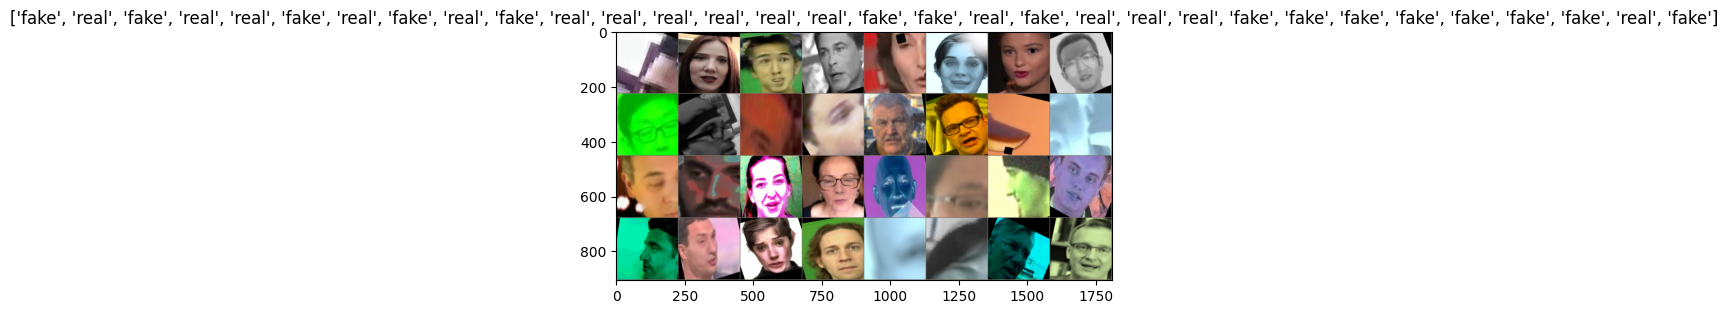

In [11]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, lr,
                plateau_threshold=1e-4, early_stop_patience=3, max_epochs=float("inf"), 
                max_batches=float("inf")):
    since = time.time()
    
    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.9)

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=2, factor=0.1, 
                                                  threshold=plateau_threshold)

    # Temp dir to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        old_tr_loss = None
        plateau_ctr = 0
        early_stop = False
        epoch = 0
        while not early_stop and epoch<=max_epochs:
            epoch += 1
            print(f'Epoch {epoch}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval() # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                
                # iter over data
                batch_ctr=0
                for inputs, labels in dataloaders[phase]:
                    batch_ctr+=1
                    if batch_ctr>max_batches:
                        break
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the param gradients
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                if phase == 'val':
                    scheduler.step(metrics=epoch_loss)

                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                if phase == 'train':
                    if epoch>1 and old_tr_loss - epoch_loss<plateau_threshold:
                        plateau_ctr += 1
                        if plateau_ctr >= early_stop_patience:
                            print("Early stoppage")
                            early_stop = True
                    old_tr_loss = epoch_loss
                
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
        
            print()
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        
        #load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [39]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            ouputs = model(inputs)
            _, preds = torch.max(ouputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [45]:
# Train for 5 epochs to get learning rate
for lr in [1e-3, 1e-4, 1e-5]:
    
    print('\n')
    print('-'*30)
    print(f'trying lr={lr}')
    print('-'*30)
    print('\n')
    
    model_ft = models.resnet50(weights='IMAGENET1K_V2')
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))

    nn.init.kaiming_normal_(model_ft.fc.weight, mode='fan_in', nonlinearity='leaky_relu')

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    
    train_model(model_ft, criterion, lr=lr,
                       loss_threshold = 1e-5, 
                       max_epochs = 3, early_stop_patience=3,
                      max_batches = float("inf"))



------------------------------
trying lr=0.01
------------------------------


Epoch 1
----------
train Loss: 0.9077 Acc: 0.5001
val Loss: 0.6911 Acc: 0.5309

Epoch 2
----------
train Loss: 1.0294 Acc: 0.4971
val Loss: 0.7042 Acc: 0.5049

Epoch 3
----------
train Loss: 0.8049 Acc: 0.4971
val Loss: 0.7817 Acc: 0.5049

Epoch 4
----------
train Loss: 0.7567 Acc: 0.5039
val Loss: 0.8111 Acc: 0.4951

Epoch 5
----------
train Loss: 0.7119 Acc: 0.5057
val Loss: 0.7235 Acc: 0.5049

Epoch 6
----------
train Loss: 0.6966 Acc: 0.4995
val Loss: 0.6937 Acc: 0.5049

Training complete in 11m 43s
Best val Acc: 0.530864


------------------------------
trying lr=0.001
------------------------------


Epoch 1
----------
train Loss: 0.7673 Acc: 0.5009
val Loss: 0.7175 Acc: 0.5212

Epoch 2
----------
train Loss: 0.6982 Acc: 0.5038
val Loss: 0.7234 Acc: 0.5045

Epoch 3
----------
train Loss: 0.6992 Acc: 0.5055
val Loss: 0.7130 Acc: 0.4943

Epoch 4
----------


KeyboardInterrupt: 

lr=0.01 and lr=0.001 proved to be too big for resnet50. We settled on lr=0.0001

In [ ]:
save_path = "/kaggle/working/"

In [ ]:
# train resnet152
model_ft = models.resnet152(weights='IMAGENET1K_V2')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

nn.init.kaiming_normal_(model_ft.fc.weight, mode='fan_in', nonlinearity='leaky_relu')

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

train_model(model_ft, criterion, lr=0.0001,
                   plateau_threshold = 1e-4, 
                   max_epochs = float("inf"), early_stop_patience=3,
                  max_batches = float("inf"))

torch.save(model_ft.state_dict(), os.path.join(save_path, "best_resnet.pt"))


In [ ]:
# train efficientnetv2 large
model_ft = models.efficientnet_v2_l(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

nn.init.kaiming_normal_(model_ft.fc.weight, mode='fan_in', nonlinearity='leaky_relu')

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

train_model(model_ft, criterion, lr=0.0001,
                   plateau_threshold = 1e-4, 
                   max_epochs = float("inf"), early_stop_patience=3,
                  max_batches = float("inf"))

torch.save(model_ft.state_dict(), os.path.join(save_path, "best_efficientnet.pt"))


In [ ]:
# train vgg16
model_ft = models.vgg16(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

nn.init.kaiming_normal_(model_ft.fc.weight, mode='fan_in', nonlinearity='leaky_relu')

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

train_model(model_ft, criterion, lr=0.0001,
                   plateau_threshold = 1e-4, 
                   max_epochs = float("inf"), early_stop_patience=3,
                  max_batches = float("inf"))

torch.save(model_ft.state_dict(), os.path.join(save_path, "best_vgg.pt"))
